# 🎯 Project: The Automated Task Manager

Welcome to your hands-on AI application build! Today, you aren't just writing code; you are building a tool that solves a common corporate headache: turning messy meeting minutes into assigned tasks.

## The Workflow
We will follow the exact same path a Machine Learning Engineer takes:

- Exploration: Understanding the relationship between task descriptions and employees.

- Training: Experimenting with "Brains" (Classifiers) like SVMs and Neural Networks to see which one "learns" best.

- Deployment: Wrapping your best model into a professional-looking web application that runs directly in this notebook.

## The Problem
Our organization has a historical dataset of tasks assigned to specific employees. We want to automate the assignment of new tasks extracted from future meeting minutes.

## 📊 Section 1: Data Exploration
Before training our AI model, we first need to understand the data it will learn from. In our dataset, each row represents a real work task. It contains:

*   Task Description: The actual text (e.g., "Review the employment contracts").
*   Employee ID: The unique number for that role. This is the target label the model actually learns to predict.
* Role: The job title or department (e.g., "HR Specialist"). This is the human-readable label.
*   Task Embedding: The numerical representation of the task. (Think of this as the "computer-readable" version of the sentence).


🎯 Our goal is to train an AI system that can learn patterns from past tasks and make intelligent assignments in the future. But before training the model, we must check whether our data is fair, balanced, and meaningful.

### ⚖️ Data Balance Check

How many tasks does each employee have? Are they equally represented?

Your Task: Run the code cell below and calculate the number of tasks assigned to each employee.

💡 Why this matters?

If "Employee A" has 90% of the tasks, the AI may learn to assign most new tasks to "Employee A", simply because that was the most common pattern in the past.

This means the AI would rely on historical frequency rather than truly understanding the task description. Therefore, we aim for a dataset where every employee has a similar number of tasks.

In [ ]:
#@title 📁 Download Project Data { display-mode: "form" }

import os
import requests
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

def download_github_files(branch, folder_path, files):
    """
    Downloads a list of files from a specific GitHub branch into a Drive folder.
    """
    # Ensure the directory exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Created directory: {folder_path}")

    base_url = f"https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/{branch}/week1/task_meeting/data"

    for file_name in files:
        url = f"{base_url}/{file_name}"
        destination = os.path.join(folder_path, file_name)

        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(destination, "wb") as f:
                    f.write(response.content)
                print(f"📥 Successfully saved: {file_name}")
            else:
                print(f"❌ Failed to download {file_name} (Status: {response.status_code})")
        except Exception as e:
            print(f"⚠️ Error downloading {file_name}: {e}")

# --- CONFIGURATION ---
BRANCH = "week1/task_meeting"
DATASET_FOLDER = "/content/drive/MyDrive/BMAI/week1/task_meeting/data"

# List your 4 files here
files_to_download = [
    "tasks_dataset_simple.csv",
    "dataset_tasks_employee_healthcare_overlapping.csv",
    "dataset_transcripts_meetings_healthcare_overlapping.csv",
    "tasks_dataset_llm.csv",
]

# Run the download
download_github_files(BRANCH, DATASET_FOLDER, files_to_download)

Mounted at /content/drive
📥 Successfully saved: tasks_dataset_simple.csv
📥 Successfully saved: dataset_tasks_employee_healthcare_overlapping.csv
📥 Successfully saved: dataset_transcripts_meetings_healthcare_overlapping.csv
📥 Successfully saved: tasks_dataset_llm.csv


Dataset Loaded Successfully!
Total Rows: 1000
--- Human vs. Machine Representation ---


,task_description,task_embedding,role,employee_id
825,Launch the social media campaign to increase b...,"[0.0177070033, -0.071468778, -0.0279924013, -0...",marketing,4
551,Interview the team building event to ensure co...,"[-0.0483719707, 0.0808125064, -0.00511534, -0....",hr_specialist,2
11,Refactor the authentication service to fix a c...,"[-0.136163563, 0.0288777873, -0.0198543929, -0...",backend_dev,0
702,Resolve the user ticket in the helpdesk system.,"[-0.0066793547, 0.0285666753, -0.00965144858, ...",customer_support,3
665,Reply to the bug report for the enterprise cli...,"[-0.0465046912, -0.00438862154, -0.0175791569,...",customer_support,3


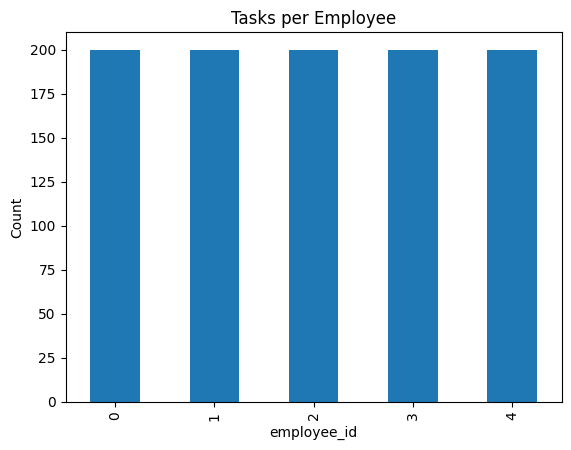

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the CSV file
df = pd.read_csv(os.path.join(DATASET_FOLDER, 'tasks_dataset_simple.csv'))

# Convert embeddings from text into numerical values so the AI model can learn from them.
df['task_embedding'] = df['task_embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ")
)

# 3. Preview the data
print(f"Dataset Loaded Successfully!")
print(f"Total Rows: {len(df)}")
# Displaying the 'Hybrid' view
print("--- Human vs. Machine Representation ---")
display(df.sample(5))

# Show distribution
df['employee_id'].value_counts().plot(kind='bar', title="Tasks per Employee")
plt.ylabel("Count")
plt.show()

## 🧠 Section 2: Now we train our model!

We will now use the emb column as our input ($X$) and the emp_id as our target ($y$).
Neural Networks are powerful but can "overfit" (memorize) small datasets. SVMs are more robust for smaller samples. Maybe Random forests are better. Which one performs better on our test data?

## Section 2.1 - YOUR TASK - Try using SVMs?
TODO, using scikit-learn

## Section 2.2 - YOUR TASK - Try using Random Forests?
TODO, using scikit-learn

## Section 2.3 - YOUR TASK - Try using Neural Networks?
TODO, using **Pytorch**

## Section 2.4 - YOUR TASK - Compare and choose the best model
TODO, using **Pytorch**

## 🚀 Section 3: The Integrated Manager App

This cell launches the interface. The "Magic" happens in the orchestrator function, which connects the External Service (Extraction) to Your Brain (Classification).

### Section 3.1 - YOUR TASK - Launch the inference in the app

> ⚠️ **Warning:**
> Make sure that you saved your model in the `best_model` variable before running the app.


In [36]:
#@title Run the Web app { display-mode: "form" }

import pandas as pd
import json

# Load the datasets from your Drive path
DATASET_PATH = "/content/drive/MyDrive/BMAI/week1/task_meeting/data"
df_meetings = pd.read_csv(f"{DATASET_PATH}/dataset_transcripts_meetings_healthcare_overlapping.csv")
df_tasks = pd.read_csv(f"{DATASET_PATH}/dataset_tasks_employee_healthcare_overlapping.csv")

def getMeetingMinutes(meeting_id):
    """
    Fetches the transcript for a specific meeting ID.
    Note: meeting_id comes from JS as an integer.
    """
    # Filter for the specific meeting
    meeting_row = df_meetings[df_meetings['meeting_id'] == int(meeting_id)]

    if meeting_row.empty:
        return {'error': 'Meeting not found', 'meeting_id': meeting_id}

    # Return a dictionary (Colab bridge handles the conversion to JS object)
    return meeting_row.iloc[0]['meeting_transcript']


def assignTasks(meeting_id):
    """
    Finds tasks associated with a meeting and returns structured employee assignments.
    """
    # 1. Get tasks for this meeting
    tasks_for_meeting = df_tasks[df_tasks['meeting_id'] == int(meeting_id)]

    response_list = []

    for _, row in tasks_for_meeting.iterrows():
        # Here you would normally run: predictions = best_model.predict(row['task_embedding'])
        # For this example, we use the data already in the CSV

        task_info = {
            "task": row['task_description'],
            "owner_id": int(row['employee_id']),
            "owner_name": f"Employee {row['employee_id']}", # Replace with name lookup if available
            "role": row['role'],
            # "embedding": row['task_embedding']
        }
        response_list.append(task_info)

    # Returning a list of dicts is the safest way to avoid escaping issues in Colab
    return json.dumps(response_list)

# Register these so JS can see them
from google.colab import output
output.register_callback('getMeetingMinutes', getMeetingMinutes)
output.register_callback('assignTasks', assignTasks)

# --- THE WEB INTERFACE ---
url = f"https://raw.githubusercontent.com/eth-bmai-fs26/project/refs/heads/{BRANCH}/week1/task_meeting/task_assigner_app_colab.html"
response = requests.get(url)
response.raise_for_status() # Check for 404/500 errors
html_app = response.text
IPython.display.display(IPython.display.HTML(html_app))